# Predict household poverty from satellite imagery data

Using code from run_grid.py, adjust the process to include feature extraction using CNN and changing target to poverty levels.
***
**ML pipeline steps in detail here:**  
1. Import and prep data  
    - Import BISP data  
    - Choose transformation for target variable (poverty)  
    - Import NTL (viirs) data  
    - Match BISP HHs to coordinates  
    - Join Bisp data and NTL data  
    - Map DTL image files to data  
<br>
2. Use CNN to extract features from DTL  
    - Prep DTL, load CNN, and extract features  
    - Select extracted features to include using PCA  
    - Add selected extracted features to data   
<br>
3. Split data into test/train sets  
***
**ML pipline steps handled by run_grid.py:** 
4. Train and evaluate models (run grid search). For each regressor-hyperparameter combination:  
    - Train regressor with given hyperparameters and training data and labels
    - Generate predicted labels for test data with trained regressor
    - Evaluate regressor-hyperparameter performance against actual test labels

In [1]:
import os
import math
import pickle
import numpy as np
import pandas as pd 
import geopandas as gpd

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Specify autoreload
%load_ext autoreload
%autoreload 2

# Import configuration file and feature extraction file
import config as cf
import feature_extraction as fe

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1 

# Data file path 
# final_data_file_path = "/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites/Data/FinalData"

# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data")

# 1. Import data and prep data

### 1.1 Import BISP data

In [4]:
#### Predict Changes
# DATA_PATH = os.path.join(final_data_file_path, 'BISP','Merged Datasets', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')
# DATA_PATH = os.path.join('/Users/robmarty/Desktop/', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')

#### Predict Levels
DATA_PATH = os.path.join('BISP', 'bisp_socioeconomic_satellite_panel_full_satPovNAsRemoved_1hh.csv')

df = pd.read_csv(DATA_PATH)
df.shape

(4528, 502)

In [5]:
# Restrict to Year
df = df[df['year'] == 2014]
df.shape

(3273, 502)

### 1.2 Choose transformation for target (poverty)

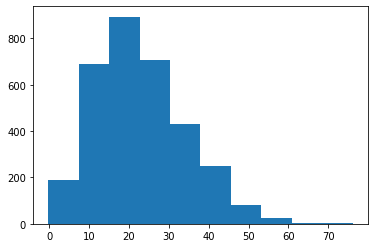

In [7]:
# Look at distribution
plt.hist(df['pscores']);

In [8]:
### Changes
#df['pscores_bin'] = df['pscores'] < 0

#### Levels
#df = df.loc[df['survey_round'] != 1]
#df['pscores_bin'] = df['pscores'] <= (df['pscores'].median())
#df['pscores_bin'] = df['pscores_poor']

### Target as Quantiles
#df['pscores_bin'] = pd.qcut(df['pscores'], 4, labels=False)
#df['pscores_2011'].value_counts()
#df['pscores_bin'] = df['pscores'] < 0

### Binary
# df = df[df['pscores_bin'] != 1]
# df = df[df['pscores_bin'] != 2]
# df['pscores_bin'] = (df['pscores_bin'] == 0)

### Clustered by K-Means
pscores = df['pscores'].to_numpy().reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
df['pscores_bin'] = discretizer.fit_transform(pscores)

df.pscores_bin.value_counts()

1.0    970
2.0    836
0.0    701
3.0    569
4.0    197
Name: pscores_bin, dtype: int64

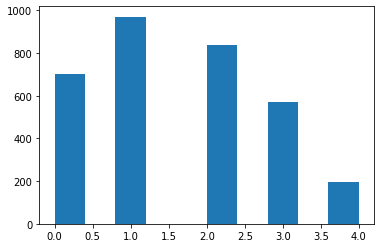

In [9]:
plt.hist(df['pscores_bin'], range=[0, 4]);

### 1.3 Import NTL data

In [236]:
# Load satellite data
viirs_gdf = gpd.read_file('satellite_raw/VIIRS/viirs_annual_polygon.geojson')
viirs_gdf = viirs_gdf[['median_rad_2014', 'tile_id', 'geometry']]
viirs_gdf.head(2)

,median_rad_2014,tile_id,geometry
0,0.179258,42.0,"POLYGON ((74.66347 37.06224, 74.67021 37.06224, 74.67021 37.05551, 74.66347 37.05551, 74.66347 37.06224))"
1,0.207353,42.0,"POLYGON ((74.67021 37.06224, 74.67695 37.06224, 74.67695 37.05551, 74.67021 37.05551, 74.67021 37.06224))"


### 1.4 Match BISP HHs to Coordinates

In [238]:
# Load BISP coordinate info
coords = pd.read_stata('BISP/GPS_uid_crosswalk.dta')

from math import floor
def get_lat_lon(number):
    deg = floor(number / 100)
    min = floor(number - (100 * deg))
    sec = 100 * (number - (100 * deg) - min)
    degree = deg + (min / 60) + (sec / 3600)
    return degree

# Drop NAs
coords = coords[~coords['GPSN'].isna()]

# Get lat, lon
coords['lat'] = coords['GPSN'].apply(lambda x: get_lat_lon(x))
coords['lon'] = coords['GPSE'].apply(lambda x: get_lat_lon(x))

# Convert uid to integer
coords['uid'] = coords['uid'].astype(int)

# Create geopandas
coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords['lon'], coords['lat']))
coords.head()

,GPSN,GPSE,uid,lat,lon,geometry
0,3349.405,7241.680,104989,33.827917,72.702222,POINT (72.70222 33.82792)
1,3349.403,7241.698,100389,33.827861,72.702722,POINT (72.70272 33.82786)
2,3349.392,7241.730,101236,33.827556,72.703611,POINT (72.70361 33.82756)
3,3349.383,7241.486,105557,33.827306,72.696833,POINT (72.69683 33.82731)
4,3349.370,7241.639,101915,33.826944,72.701083,POINT (72.70108 33.82694)


In [239]:
# Match coords to HHs in df
gdf_bisp = coords.merge(df, left_on='uid', right_on='uid')
gdf_bisp.shape

(3273, 508)

### 1.5 Join Bisp data and NTL data
Bisp HHs located in an NTL tile/poly are linked to that NTL radiance value 

In [241]:
# Spatial join HHs with satellite viirs
gdf = gpd.sjoin(viirs_gdf, gdf_bisp, how="inner", op='intersects').reset_index(drop=True)
# Reset index because multiple HHs may belong to one NTL tile

In [242]:
# Inspect range of tiles represented
print(gdf.shape)
gdf['tile_id'].unique()

(3259, 511)


array([40., 36., 38., 37., 32., 33., 31., 34., 28., 29., 30., 27., 26.,
       25., 23., 20., 21., 22., 24., 19., 15., 14., 13.,  9.,  8., 10.,
        1.,  2.])

### 1.6 Map DTL image files to data

In [245]:
DTL_directory = os.path.join('satellite_raw', 'Landsat', '2014')
DLT, processed_gdf = fe.map_DTL_NTL(gdf, DTL_directory)

In [250]:
print(processed_gdf.shape)
print('Note: {} observations were dropped due to irregular DTL sizes'.format(gdf.shape[0] - processed_gdf.shape[0]))

(3223, 511)
Note: 36 observations were dropped due to irregular DTL sizes


In [301]:
# Keep Select Columns
df_viirs = processed_gdf.filter(regex='viirs').filter(regex='_2km')
df_landsat = processed_gdf.filter(regex='^b').filter(regex='_1km')
df_osm = processed_gdf.filter(regex='fclass').filter(regex='meters')
df_facebook = processed_gdf.filter(regex='^estimate_dau')

df_y = processed_gdf[['pscores', 'pscores_bin']]

# Reset index because 36 observations and indexes dropped throughout
df_final = df_y.join(df_osm).join(df_facebook).reset_index(drop=True)

# 2. Use CNN to extract features from DTL

### 2.1 Prep DTL, load CNN, and extract features

In [303]:
# Reshape DTL like in CNN training
height, width, channels = 25, 26, 7
DLT = DLT.reshape((DLT.shape[0], height, width, channels))
print('DTL after reshaping: {}'.format(DLT.shape))

DTL after reshaping: (3223, 25, 26, 7)


In [2]:
### Save objects for later
#processed_gdf.to_pickle('saved_objects/processed_gdf.pkl')
#df_final.to_pickle('saved_objects/df_final.pkl')
#np.save('saved_objects/poverty_DLT', DLT)
#viirs_gdf.to_pickle('saved_objects/viirs_gdf.pkl')

### Restart here
processed_gdf = pd.read_pickle('saved_objects/processed_gdf.pkl')
df_final = pd.read_pickle('saved_objects/df_final.pkl') #target = pscores_bin k-means clustering like NLT
DLT = np.load('saved_objects/poverty_DLT.npy')
viirs_gdf = pd.read_pickle('saved_objects/viirs_gdf.pkl')

In [3]:
# Load CNN
from keras.models import load_model
model = load_model('best_CNN.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 21, 22, 64)        11264     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 10, 11, 64)        0         
_________________________________________________________________
flatten1 (Flatten)           (None, 7040)              0         
_________________________________________________________________
dense1 (Dense)               (None, 100)               704100    
_________________________________________________________________
dense2 (Dense)               (None, 5)                 505       
Total params: 715,869
Trainable params: 715,869
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Extract features
df_features = fe.extract_features(model, DLT, 'dense1')
df_features

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,feat_96,feat_97,feat_98,feat_99
0,0.0,0.0,0.0,2366.600586,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,2522.061035,0.0,0.0,0.000000,3883.045410,1161.409058,0.0,0.0,0.0,0.000000,238.642548,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1133.368286,0.0,0.000000,0.000000,0.0,0.000000,580.302917,0.0,0.0,0.0,3263.840088,0.0,4744.113281,1212.678589,0.000000,0.0,255.813400,0.000000,2941.686523,783.1427,2031.683960,0.000000,0.000000,1191.658081,0.0,0.000000,2260.906006,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,823.855957,0.000000,0.000000,0.0,0.0,0.0,0.0,5688.450684,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,2094.69873,0.0,0.0,0.0,0.0,0.0,76.956139,0.0,0.0,0.0,50.866501,0.000000,0.0,774.081848,0.000000,64.622139,888.501709,0.0,2103.291504
1,0.0,0.0,0.0,0.000000,709.257812,0.000000,0.000000,0.0,0.0,0.0,0.0,1090.323486,940.399719,0.000000,0.0,0.0,543.331787,2957.527100,1878.533325,0.0,0.0,0.0,43.681442,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,2097.463135,0.0,0.000000,0.000000,0.0,363.357880,0.000000,0.0,0.0,0.0,0.000000,0.0,733.075867,0.000000,1149.308472,0.0,0.000000,555.367981,2108.306396,0.0000,1365.018066,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,185.2397,339.253754,0.0,0.000000,2376.997070,403.180664,0.0,0.0,0.0,0.0,4283.085938,0.000000,0.0,0.0,0.0,0.000000,575.385620,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,801.021912,418.039246,0.0,0.000000,0.000000,0.000000,0.000000,0.0,976.908203
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2059.481201,0.000000,0.0,0.0,0.0,0.000000,5.064293,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2059.481201,0.000000,0.0,0.0,0.0,0.000000,5.064293,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,

### 2.2 Select extracted features to include using PCA

In [5]:
pca = PCA(n_components=10)
pca.fit(df_features)
print('Explained variance ratio: {}'.format(pca.explained_variance_ratio_))

features_pca = pca.transform(df_features)
column_names = ['pc_%01d' %i for i in range(0,10)]
df_features_pca = pd.DataFrame(data=features_pca, columns=column_names)
df_features_pca

Explained variance ratio: [0.46551076 0.20630345 0.06505419 0.06242418 0.03172474 0.02843885
 0.01694803 0.01457829 0.01393106 0.01331444]


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
0,7585.056152,3182.065430,3086.046143,362.283813,-3541.769531,651.395081,-972.302124,1833.604492,1187.974731,-1297.977661
1,4837.710938,1970.662231,894.087585,1319.083984,118.299652,-1669.850220,-380.033447,-204.436188,-775.355469,-286.463165
2,2020.174316,-1018.419983,222.297989,-434.916870,-168.406250,-306.023865,549.103882,-371.523682,-162.585846,139.218536
3,2020.174316,-1018.419983,222.297989,-434.916870,-168.406250,-306.023865,549.103882,-371.523682,-162.585846,139.218536
4,2020.174316,-1018.419983,222.297989,-434.916870,-168.406250,-306.023865,549.103882,-371.523682,-162.585846,139.218536
...,...,...,...,...,...,...,...,...,...,...
3218,1313.572998,-1360.942627,33.014301,-55.348503,101.148849,6.001366,175.175705,-369.247681,208.005386,113.489929
3219,1313.572998,-1360.942627,33.014301,-55.348503,101.148849,6.001366,175.175705,-369.247681,208.005386,113.489929
3220,1313.572998,-1360.942627,33.014301,-55.348503,101.148849,6.001366,175.175705,-369.247681,208.005386,113.489929
3221,2542.412842,-794.536133,245.318192,-268.124634,102.294968,-488.486389,119.823463,-527.099182,833.071167,-147.635406


### 2.3 Add selected extracted features to data

In [6]:
df_final = df_final.join(df_features_pca).drop(columns=['pscores'])
df_final

,pscores_bin,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,dist_osm_fclass_motorway_meters,dist_osm_fclass_living_street_meters,estimate_dau_all,estimate_dau_male,estimate_dau_female,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
0,2.0,3792.357952,35917.095934,43.583917,13075.891660,11.621799,11474.921382,8160.699002,149159.485989,15756.970525,0,0,0,7585.056152,3182.065430,3086.046143,362.283813,-3541.769531,651.395081,-972.302124,1833.604492,1187.974731,-1297.977661
1,1.0,3165.949020,36611.060520,4.980330,12488.112391,87.400393,11824.485331,7700.984802,148553.674436,15796.078642,0,0,0,4837.710938,1970.662231,894.087585,1319.083984,118.299652,-1669.850220,-380.033447,-204.436188,-775.355469,-286.463165
2,1.0,3014.708699,36518.572312,73.896161,12772.653817,375.076111,11427.455346,7392.205527,148370.227522,16233.078724,0,0,0,2020.174316,-1018.419983,222.297989,-434.916870,-168.406250,-306.023865,549.103882,-371.523682,-162.585846,139.218536
3,3.0,3066.888739,36474.995373,24.791045,12796.758541,400.119781,11423.093075,7441.220550,148422.609270,16205.552093,0,0,0,2020.174316,-1018.419983,222.297989,-434.916870,-168.406250,-306.023865,549.103882,-371.523682,-162.585846,139.218536
4,1.0,3089.591174,36450.085615,0.208842,12817.844473,421.441879,11408.873066,7457.007066,148443.676013,16204.936983,0,0,0,2020.174316,-1018.419983,222.297989,-434.916870,-168.406250,-306.023865,549.103882,-371.523682,-162.585846,139.218536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218,1.0,1914.085972,48633.104101,2016.437865,631.035101,72286.291293,1445.935959,6340.847990,95081.405194,2500.320481,0,0,0,1313.572998,-1360.942627,33.014301,-55.348503,101.148849,6.001366,175.175705,-369.247681,208.005386,113.489929
3219,0.0,1649.096528,48705.592566,1736.509063,365.050566,72204.953064,1248.008186,6614.281203,94930.990709,2226.293917,0,0,0,1313.572998,-1360.942627,33.014301,-55.348503,101.148849,6.001366,175.175705,-369.247681,208.005386,113.489929
3220,0.0,1598.886011,48676.729092,1672.869967,266.730664,72131.745801,1240.648872,6676.780389,94843.078163,2129.095614,0,0,0,1313.572998,-1360.942627,33.014301,-55.348503,101.148849,6.001366,175.175705,-369.247681,208.005386,113.489929
3221,0.0,1164.877045,49118.407943,1287.060051,187.659418,72411.716651,760.862728,7089.119024,95011.811134,2030.397039,0,0,0,2542.412842,-794.536133,245.318192,-268.124634,102.294968,-488.486389,119.823463,-527.099182,833.071167,-147.635406


# 3. Split data into test/train and normalize

In [7]:
LABEL = 'pscores_bin'
TEST_SIZE = 0.2

# Separate feature sets from label sets
x_df = df_final.drop(labels=[LABEL], axis=1)
y_df = df_final[LABEL]

# Split into test and train sets for features and labels
x_train, x_test, y_train, y_test =  train_test_split(x_df, y_df, test_size=TEST_SIZE)

# Normalize
x_scaler = StandardScaler().fit(x_train)
for df in (x_train, x_test):
    x_scaler.transform(df)

In [8]:
x_train.head()

,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,dist_osm_fclass_motorway_meters,dist_osm_fclass_living_street_meters,estimate_dau_all,estimate_dau_male,estimate_dau_female,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
50,513.118067,40.402994,1972.199287,1238.024607,43331.083497,526.023935,3074.706814,86088.265734,31926.857601,0,0,0,13205.432617,8593.343750,-5670.835449,-1661.001953,-3083.567627,3144.125488,-2099.905273,-1391.788940,1029.637329,883.274109
1610,427.074241,740.577117,240.621050,918.229162,1858.534935,938.291093,1154.363438,38367.580766,2048.953499,17838,16970,1572,-1371.938110,1094.665161,-199.113678,796.802734,-268.730560,-185.447998,107.544144,231.789520,8.267117,135.875458
2265,557.549265,2068.046093,1901.528099,4402.415311,1934.998810,2211.194069,3712.838346,91269.823577,87274.641327,498,748,0,1278.752075,-1431.109863,123.541496,-371.841492,157.050964,25.780350,23.746342,-256.578308,-104.409851,45.521477
3212,241.294395,20570.251942,2193.836831,28463.221430,47403.074089,28081.187440,37269.424586,103255.142663,23241.276193,0,0,0,1016.311035,-1419.364868,66.202469,-171.545578,167.900604,198.177948,90.915230,-177.115906,-103.473343,209.099884
1219,1344.539011,564.555000,23.361256,1102.922485,1569.568899,1002.267048,294.679267,7123.290255,3729.042074,242708,195330,55404,1101.930786,-1528.644897,55.809448,-220.611343,207.684509,223.885971,-33.872543,-159.578430,-90.652054,123.297775


In [9]:
# Check lengths
print('Train lengths match? {}'.format(len(x_train) == len(y_train)))
print('Test lengths match? {}'.format(len(x_test) == len(y_test)))

# Check target values
print(y_train.value_counts())
print(y_test.value_counts())

Train lengths match? True
Test lengths match? True
1.0    758
2.0    663
0.0    551
3.0    452
4.0    154
Name: pscores_bin, dtype: int64
1.0    199
2.0    158
0.0    140
3.0    109
4.0    39 
Name: pscores_bin, dtype: int64


# 4. Train and Evaluate Regressors

In [11]:
# Using code in run_grid.py
from run_grid import train_models, evaluate_models

In [12]:
# DEFINE FEATURE GROUPS
feature_dict = {'EXTRACTED_FEATURES': df_final.filter(regex='pc').columns.tolist(),
                'ALL_FEATURES': x_df.columns.tolist()}

# TRAIN MODELS AND EXPORT ERRORS
parameters = cf.GRID_TEST_CLASS
training_errors = train_models(parameters, x_train, y_train, feature_dict)
training_errors.to_csv(os.path.join('output', 'errors.csv'))

# PREDICT LABELS AND EVALUATE RESULTS
trained_obj_list = [f for f in os.listdir('output') if f.endswith('_trained.pkl')]
results_df = evaluate_models(trained_obj_list, x_test, y_test, feature_dict)
results_df.to_csv(os.path.join('output', 'results.csv'))

2020-08-10 15:25:42.050470 Saving data to output/LinearSVC_trained.pkl
2020-08-10 15:25:42.090216 Saving data to output/DecisionTreeClassifier_trained.pkl
2020-08-10 15:25:53.449445 Saving data to output/BaggingClassifier_trained.pkl
2020-08-10 15:26:06.731616 Saving data to output/GradientBoostingClassifier_trained.pkl
2020-08-10 15:26:08.581782 Saving data to output/RandomForestClassifier_trained.pkl
2020-08-10 15:26:08.601882    Evaluating GradientBoostingClassifier_trained.pkl
2020-08-10 15:26:08.912202    Evaluating DecisionTreeClassifier_trained.pkl
2020-08-10 15:26:09.027471    Evaluating RandomForestClassifier_trained.pkl
2020-08-10 15:26:09.576536    Evaluating SVC_trained.pkl
2020-08-10 15:26:09.581060    Evaluating BaggingClassifier_trained.pkl
2020-08-10 15:26:10.857971    Evaluating LinearSVC_trained.pkl
